In [3]:
from sklearn.cluster import KMeans
import pandas as pd
import dask.dataframe as dd
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Input, Flatten, Dot, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

c:\Users\Luis\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
scores = pd.read_csv('../data/ml-32m/ratings.csv')
#scores = pd.read_csv('../data/scores.csv')
movies = pd.read_csv('../data/ml-32m/movies.csv')
users = pd.read_csv('../data/ml-32m/users.csv')

In [5]:
scores['userId'].nunique()

200948

In [6]:
scores = scores[['userId', 'movieId', 'rating']]

In [7]:
scores

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0
...,...,...,...
32000199,200948,79702,4.5
32000200,200948,79796,1.0
32000201,200948,80350,0.5
32000202,200948,80463,3.5


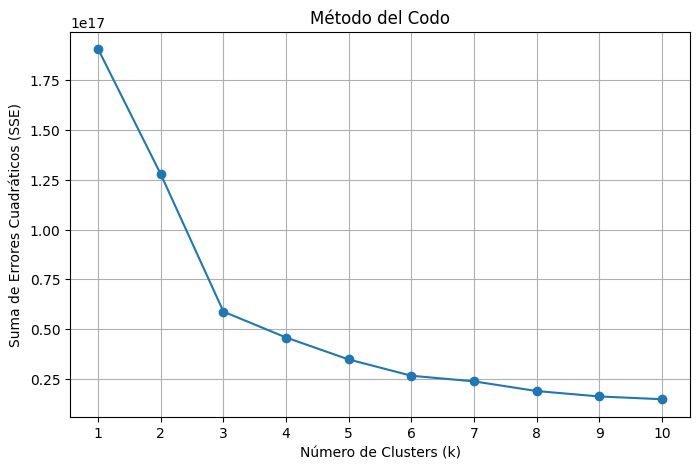

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Crear una lista para almacenar el SSE
sse = []
k_range = range(1, 11)  # Prueba valores de k de 1 a 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scores)  # Asegúrate de que X es tu matriz de características
    sse.append(kmeans.inertia_)  # Inertia es la suma de errores cuadrados

# Graficar el SSE contra k
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.xticks(k_range)
plt.grid()
plt.show()

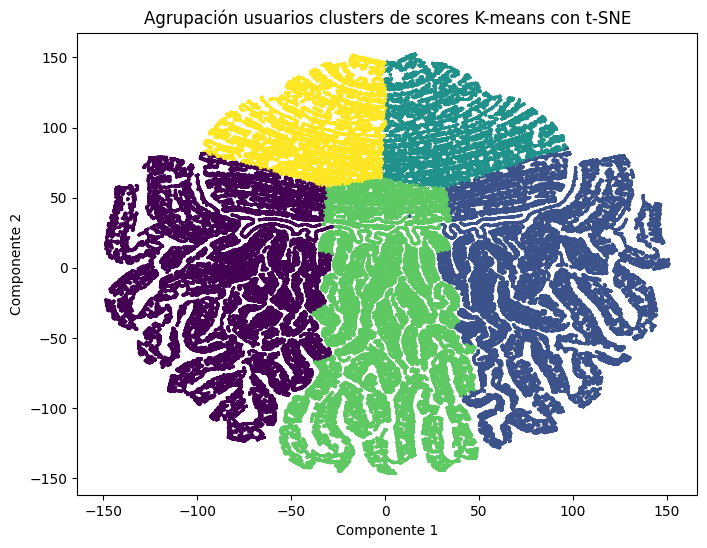

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =============================================
# 1. SELECCIÓN DE MUESTRA
# =============================================
# Seleccionamos un 1% de los datos para optimizar el rendimiento y carga computacional.
sample_size = int(0.01 * len(scores))  # 1% de la muestra
sample_indices = np.random.choice(scores.shape[0], sample_size, replace=False)

# Extraemos la muestra seleccionada
scores_sampled = scores.iloc[sample_indices]

# =============================================
# 2. ESCALADO DE LOS DATOS
# =============================================
scaler = StandardScaler()
scores_scaled = scaler.fit_transform(scores_sampled)

# =============================================
# 3. MÉTODO DEL CODO PARA DETERMINAR 'k' ÓPTIMO
# =============================================
# Usamos el método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Intentamos con k entre 1 y 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scores_scaled)
    inertia.append(kmeans.inertia_)

# Visualizamos el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Método del Codo para Determinar 'k' Óptimo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")
plt.show()

# =============================================
# 4. APLICACIÓN DE K-MEANS
# =============================================
# Usamos 'k' = 5 basándonos en el análisis anterior
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scores_scaled)

# =============================================
# 5. REDUCCIÓN DE DIMENSIONALIDAD CON t-SNE
# =============================================
# Aplicamos t-SNE para reducir las dimensiones a 2 para la visualización
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scores_scaled)

# =============================================
# 6. VISUALIZACIÓN DE LOS CLUSTERS
# =============================================
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title("Agrupación de Usuarios con K-means y t-SNE")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.grid(True, alpha=0.3)
plt.show()

# =============================================
# 7. ANÁLISIS Y DEFINICIÓN DE CLUSTERS
# =============================================
# Análisis de las características de cada cluster
scores_sampled['cluster'] = clusters

# Agrupar por clusters y calcular estadísticas relevantes
cluster_summary = scores_sampled.groupby('cluster').agg({
    'rating': ['mean', 'count'],  # Promedio y cantidad de calificaciones
    'movieId': 'nunique',  # Número de películas únicas
})

# Mostrar estadísticas de los clusters
print("Resumen de Clusters:")
print(cluster_summary)

# Análisis cualitativo por cada cluster
for cluster in range(5):
    print(f"\nCluster {cluster}:")
    print(f"- Promedio de rating: {cluster_summary.loc[cluster, ('rating', 'mean')]:.2f}")
    print(f"- Total de ratings: {cluster_summary.loc[cluster, ('rating', 'count')]}")
    print(f"- Número de películas calificadas: {cluster_summary.loc[cluster, ('movieId', 'nunique')]}")






In [8]:
scores_sampled # se tomaron 320.000 muestras al azar con usuarios, movieID y el rating por cada una de las categorias. K means pudo agrugar por tipo de ratings a los usuarios.

,userId,movieId,rating
15870359,99406,171763,2.0
28010895,175447,203322,5.0
18973769,118765,356,4.5
7551391,47282,3489,3.0
26275693,165036,594,4.0
...,...,...,...
11114702,69534,41025,4.0
23300206,145907,3275,3.5
9409328,58798,56757,1.5
15094141,94521,4958,4.5
